In [ ]:
# !pip install pytesseract
!pip install paddlepaddle paddleocr

In [1]:
from PIL import Image
import cv2
import easyocr
import cv2
import os
from ultralytics import YOLO
import cv2
import pytesseract
import requests
from PIL import Image
from io import BytesIO

In [2]:
model_dir = './runs/detect/cnr/weights'
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
class_names = {0:'Serial No', 1:'Owner Prefix', 2:'ISO1546', 3:'V Serial No', 4:'V Owner Prefix', 5:'V ISO1546'}

In [3]:
model_path = os.path.join(model_dir, 'best.pt')
print(model_path)
model = YOLO(model_path)

./runs/detect/cnr/weights\best.pt


In [4]:
def ocr_easyocr(cropped_images, languages=['en'], gpu=True):
    """
    Extracts text from a list of cropped images using EasyOCR.

    Args:
        cropped_images (list[np.ndarray]): List of cropped images (OpenCV BGR format).
        languages (list[str]): Languages for OCR (e.g., ['en', 'fr']). Default: English.
        gpu (bool): Enable GPU acceleration if available. Default: False (CPU).

    Returns:
        list[str]: List of extracted text strings.
    """
    # Initialize EasyOCR reader once (reusing it improves speed)
    reader = easyocr.Reader(languages, gpu=gpu)
    
    extracted_texts = []
    
    for img in cropped_images:
        # Convert BGR (OpenCV) to RGB (EasyOCR expects RGB)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Run OCR
        results = reader.readtext(img_rgb)
        
        # Combine all detected text in the image
        text = " ".join([detection[1] for detection in results])
        extracted_texts.append(text.strip())
    
    return extracted_texts

In [5]:
def ocr_tesseract(cropped_images, lang='eng'):
    """
    Extracts text from a list of cropped images using Tesseract OCR.

    Args:
        cropped_images (list[np.ndarray]): List of cropped images (OpenCV BGR format).
        lang (str): Language code for OCR (e.g., 'eng', 'ind'). Default: English.

    Returns:
        list[str]: List of extracted text strings.
    """
    extracted_texts = []

    for img in cropped_images:
        # Convert BGR (OpenCV) to RGB (Tesseract expects RGB)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Run OCR
        text = pytesseract.image_to_string(img_rgb, lang=lang)
        extracted_texts.append(text.strip())

    return extracted_texts


In [6]:
from paddleocr import PaddleOCR
import cv2

import numpy as np
import cv2



def ocr_paddle(cropped_images, lang='en'):
    """
    Extracts text from a list of cropped images using PaddleOCR.

    Args:
        cropped_images (list[np.ndarray]): List of cropped images (OpenCV BGR format).
        lang (str): Language code for OCR (e.g., 'en', 'ch', 'ind'). Default: English.

    Returns:
        list[str]: List of extracted text strings.
    """
    # Initialize PaddleOCR
    ocr = PaddleOCR(lang=lang, use_textline_orientation=True, text_recognition_model_name='PP-OCRv5_server_rec')

    extracted_texts = []
    for img in cropped_images:
        # Convert BGR (OpenCV) to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Run OCR
        results = ocr.predict(img_rgb)

        # Collect text results
        text_lines = []
        for line in results[0]:
            text_lines.append(line[1][0])  # line[1][0] contains recognized text

        extracted_texts.append(" ".join(text_lines).strip())

    return extracted_texts

In [19]:
from PIL import Image, ImageOps, ImageEnhance

def preprocess_image_for_ocr(input_image, scale_factor=2, denoise_strength=10, sharpness_factor=1.5):
    """
    Preprocess an image for OCR that accepts both PIL Images and NumPy arrays.
    
    Args:
        input_image (PIL.Image.Image or np.ndarray): Input image
        scale_factor (int): Factor to upscale the image. Default 2.
        denoise_strength (int): Strength for denoising. Default 10.
        sharpness_factor (float): Factor for sharpening. Default 1.5.
    
    Returns:
        numpy array: Processed image as a PIL Image object.
    """
    # Import OpenCV inside the function
    import cv2
    
    # Convert to PIL Image if it's a NumPy array
    if isinstance(input_image, np.ndarray):
        # Convert BGR to RGB if it's a color image
        if len(input_image.shape) == 3 and input_image.shape[2] == 3:
            input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(input_image)
    else:
        img = input_image.copy()
    
    # 1. Convert to grayscale (Luminosity mode)
    # if img.mode != 'L':
    #     img = img.convert('L')
    
    # 2. Resize (Upscale) using LANCZOS filter
    if scale_factor != 1:
        new_width = int(img.width * scale_factor)
        new_height = int(img.height * scale_factor)
        img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # 3. Convert to numpy array for OpenCV denoising if needed
    if denoise_strength > 0:
        import cv2
        img_np = np.array(img)
        denoised_np = cv2.fastNlMeansDenoising(img_np, h=denoise_strength, 
                                              templateWindowSize=7, 
                                              searchWindowSize=21)
        img = Image.fromarray(denoised_np)
    
    # 4. Enhance contrast
    img = ImageOps.autocontrast(img, cutoff=2)
    
    # 5. Apply sharpening
    if sharpness_factor > 1.0:
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(sharpness_factor)
        
    # # 6. Convert to black and white (binary)
    # img_bw = img.convert('L')  # Ensure grayscale
    # threshold = 128
    # # Apply threshold: pixels > threshold become white (255), else black (0)
    # binary = img_bw.point(lambda p: 255 if p > threshold else 0)
    
    # # Convert back to RGB
    # img = Image.merge('RGB', (binary, binary, binary))
    
    return np.array(img)
    
def crop_predicted_objects(image, results):
    """
    Crops detected objects from an image based on YOLO prediction results and returns them with metadata.

    Args:
        image (np.ndarray): The original image read by OpenCV.
        results (ultralytics.yolo.engine.results.Results): The results object from model.predict().

    Returns:
        tuple: A tuple containing three elements:
            - list[np.ndarray]: A list of cropped images.
            - list[str]: A list of class names for each cropped image.
            - list[float]: A list of confidence scores for each detection.
        Returns empty lists if no objects are detected.
    """
    cropped_images = []
    class_names = []
    confidences = []
    
    # Check if there are any detections
    if results.boxes is None:
        return cropped_images, class_names, confidences
    
    # Get the names of the classes from the model
    names = results.names
    
    # Get the bounding boxes, confidence scores, and class IDs from the results object
    boxes = results.boxes
    confs = boxes.conf
    class_ids = boxes.cls

    # Iterate through each detected object
    for i, box in enumerate(boxes):
        # Get the bounding box coordinates in xyxy format
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        
        # Convert coordinates to integers
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Ensure coordinates are within image boundaries
        height, width = image.shape[:2]
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(width, x2)
        y2 = min(height, y2)

        # Crop the image only if the bounding box is valid
        if x2 > x1 and y2 > y1:
            cropped_image = image[y1:y2, x1:x2]
            
            cropped_images.append(preprocess_image_for_ocr(cropped_image))
            # cropped_images.append(cropped_image)
            
            # Get the class name and confidence for this detection
            class_id = int(class_ids[i].item())
            class_name = names[class_id]
            confidence = confs[i].item()
            
            class_names.append(class_name)
            confidences.append(confidence)
            
    return cropped_images, class_names, confidences

In [20]:
def load_image(image_path_or_url):
    """Improved image loading with better error handling"""
    try:
        if image_path_or_url.startswith(('http://', 'https://')):
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
                'Accept': 'image/webp,image/apng,image/*,*/*;q=0.8'
            }
            session = requests.Session()
            response = session.get(image_path_or_url, 
                                 headers=headers, 
                                 stream=True, 
                                 timeout=10)
            response.raise_for_status()
            
            # Verify content is actually an image
            if 'image' not in response.headers.get('Content-Type', ''):
                raise ValueError("URL does not point to an image")
                
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            img = Image.open(image_path_or_url).convert('RGB')
        
        # Display image and prediction
        plt.figure(figsize=(3, 2))
        plt.imshow(img)
        plt.title(f"Image Prediction")
        plt.axis('off')
        plt.show()
        
        return img
    except requests.exceptions.RequestException as e:
        raise ValueError(f"URL error: {str(e)}")
    except IOError as e:
        raise ValueError(f"Image loading error: {str(e)}")
    except Exception as e:
        raise ValueError(f"Unexpected error: {str(e)}")
        
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import numpy as np

def show_predictions(img, results, class_names):
    """
    Display image with bounding boxes and class names from Ultralytics Results object.
    Each class is shown in a different color.

    Parameters:
    - img: The image array (e.g., NumPy array or PIL image)
    - results: Ultralytics Results object from model.predict(img)
    - class_names: Dictionary mapping class_id to class_name (e.g., model.names)
    """
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    boxes = results[0].boxes.xyxy.cpu().numpy()
    class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
    scores = results[0].boxes.conf.cpu().numpy()

    unique_classes = np.unique(class_ids)
    cmap = cm.get_cmap('tab20', len(unique_classes))
    class_colors = {cls_id: cmap(i) for i, cls_id in enumerate(unique_classes)}

    for box, class_id, score in zip(boxes, class_ids, scores):
        x1, y1, x2, y2 = box
        color = class_colors[class_id]
        class_name = class_names.get(class_id, f"Class {class_id}")

        # Draw bounding box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # Add label with class name
        label = f"{class_name} ({score:.2f})"
        ax.text(x1, y1 - 10, label, color='white', fontsize=9,
                bbox=dict(facecolor=color, alpha=0.7))

    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [21]:
# read container number records
def read_cnr(img):
    # Run inference ONLY for specific classes (e.g., person=0, car=2)
    # results = model.predict(image)  # Filter classes by ID
    results = model.predict(img, conf=0.4)  # Filter classes by ID
    
    boxes = results[0].boxes
    class_ids = boxes.cls.cpu().numpy().astype(int)
    confidences = boxes.conf.cpu().numpy()
    
    for cls_id, conf in zip(class_ids, confidences):
        class_name = model.names.get(cls_id, f"Class {cls_id}")
        print(f"- {class_name}: {conf:.2f}")
    
    show_predictions(img, results, class_names)
    cropped_images, names, confidences = crop_predicted_objects(np.array(img), results[0])

    texts = ocr_easyocr(cropped_images)
    print(texts)
    
    texts_2 = ocr_tesseract(cropped_images)
    print(texts_2)

    
    texts_3 = ocr_paddle(cropped_images)
    print(texts_3)
    
    for i, cropped_img in enumerate(cropped_images):
        # Convert from BGR (OpenCV) to RGB (Matplotlib)
        cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        
        # Display the image using matplotlib
        print(f"EasyOCR: {texts[i]}")
        print(f"Tesseract: {texts_2[i]}")
        print(f"Paddle: {texts_3[i]}")
        plt.figure()
        plt.imshow(cropped_img_rgb)
        plt.title(f"{names[i]}:{confidences[i]}")
        plt.axis('off') # Hide axes
        plt.show()

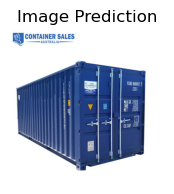


0: 640x640 1 Serial Number, 1 Owner Prefix, 1 ISO6346, 1 V Serial Number, 2 V Owner Prefixs, 1 V ISO6346, 25.6ms
Speed: 7.6ms preprocess, 25.6ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)
- V Owner Prefix: 0.94
- V ISO6346: 0.90
- Serial Number: 0.87
- V Owner Prefix: 0.68
- ISO6346: 0.66
- Owner Prefix: 0.59
- V Serial Number: 0.49


C:\Users\budik\AppData\Local\Temp\ipykernel_49096\3451555728.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_classes))


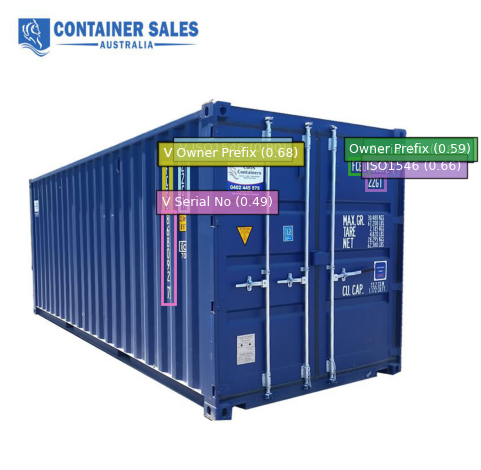

['8', '1 2 6', '868092 1U', '{ 6', '2261', 'FCBU', '0 6 8']


C:\Users\budik\AppData\Local\Temp\ipykernel_49096\2859480234.py:21: UserWarning: `lang` and `ocr_version` will be ignored when model names or model directories are not `None`.
  ocr = PaddleOCR(lang=lang, use_textline_orientation=True, text_recognition_model_name='PP-OCRv5_server_rec')
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\budik\.paddlex\official_models.


['oo', '', '868092 77', '', '', '', '']


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in C:\Users\budik\.paddlex\official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in C:\Users\budik\.paddlex\official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in C:\Users\budik\.paddlex\official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in C:\Users\budik\.paddlex\official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

['n a o t o e e e e e e e i e', 'n a o t o e e e e e e e i e', 'n a o t o e e e e e e e i e e', 'n a o t o e e e e e e e i e', 'n a o t o e e e e e e e i e e', 'n a o t o e e e e e e e i e e', 'n a o t o e e e e e e e i e']
EasyOCR: 8
Tesseract: oo
Paddle: n a o t o e e e e e e e i e


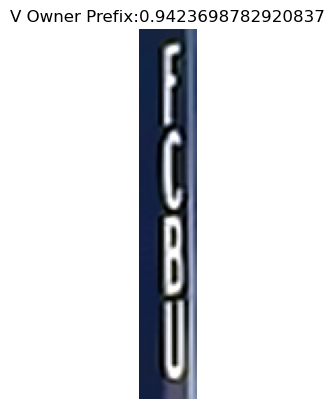

EasyOCR: 1 2 6
Tesseract: 
Paddle: n a o t o e e e e e e e i e


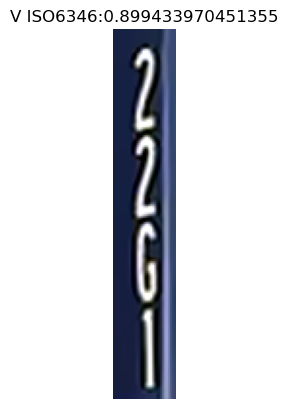

EasyOCR: 868092 1U
Tesseract: 868092 77
Paddle: n a o t o e e e e e e e i e e


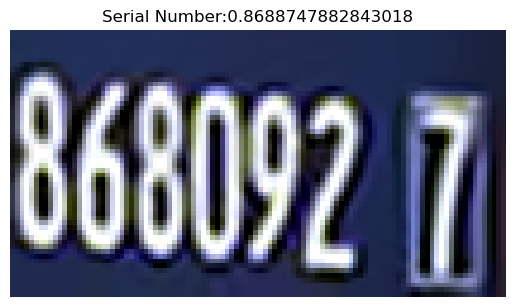

EasyOCR: { 6
Tesseract: 
Paddle: n a o t o e e e e e e e i e


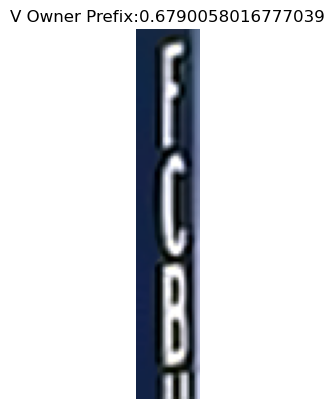

EasyOCR: 2261
Tesseract: 
Paddle: n a o t o e e e e e e e i e e


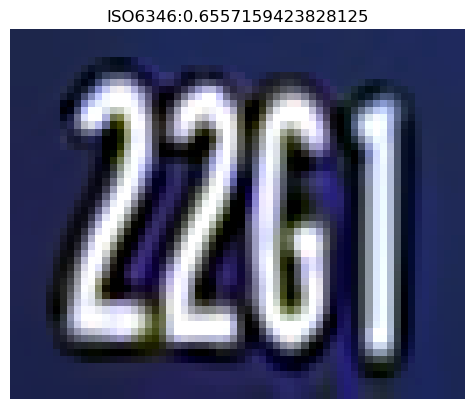

EasyOCR: FCBU
Tesseract: 
Paddle: n a o t o e e e e e e e i e e


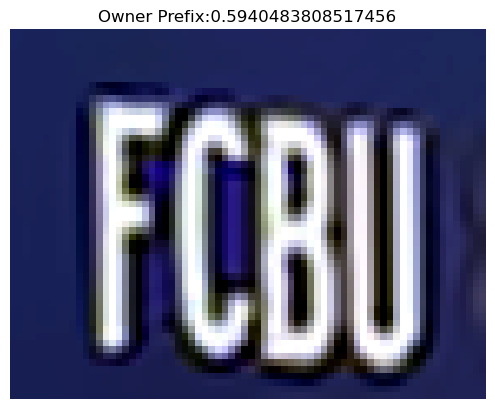

EasyOCR: 0 6 8
Tesseract: 
Paddle: n a o t o e e e e e e e i e


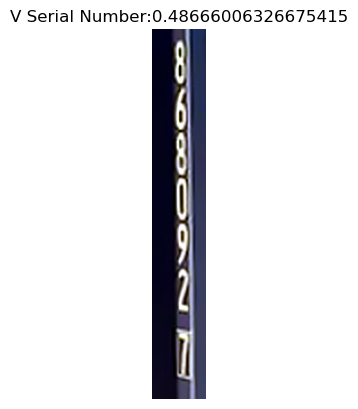

In [22]:
url_image = "https://www.contsalesaust.com.au/wp-content/uploads/20-ft-shipping-container-new-for-sale-03.jpg"  # Image URL
img = load_image(url_image)
read_cnr(img)


In [ ]:
url_image = "https://i.ebayimg.com/images/g/mDcAAOSwv4JnHvz9/s-l1200.jpg"  # Image URL
img = load_image(url_image)
read_cnr(img)


In [ ]:
url_image = "https://i.ebayimg.com/images/g/mDcAAOSwv4JnHvz9/s-l1200.jpg"  # Image URL
img = load_image(url_image)
print(type(img))
read_cnr(img)


In [ ]:

url_image = "https://5.imimg.com/data5/SELLER/Default/2024/12/472401936/HI/QV/TN/121910952/shipping-container-20ft-500x500.jpg"  # Image URL
img = load_image(url_image)
read_cnr(img)
